In [51]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import MultiLabelBinarizer
import mlflow
import mlflow.keras 
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec
import numpy as np
import tensorflow_hub as hub
import mlflow.pyfunc
import os
import tensorflow as tf
import pickle


In [52]:

mlflow.set_experiment("Text_Processing_Experiment")




<Experiment: artifact_location='file:///c:/Users/leenc/Documents/openclassrooms/p5/notebooks/mlruns/513811231573427600', creation_time=1722810345955, experiment_id='513811231573427600', last_update_time=1722810485632, lifecycle_stage='active', name='Text_Processing_Experiment', tags={}>

In [53]:
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [54]:
df = pd.read_csv('db/questions_db.csv')
print(df.head())
# pour réduire l'échantillon si nécessaire
df = df.sample(frac=0.1, random_state=42) 

del df['FavoriteCount'] # efface une colonne en attendant



                                                                                              Title  \
0                           C++ function template specialization based on the templated return type   
1                                                  How can I write a std::apply on a std::expected?   
2  App must target Android 14 (API level 34) or higher is showing even after update to API level 34   
3                        Efficiently find the number of different classmates from course-level data   
4                               Get the first and last number occuring in a (text) string in a cell   

                                                                                                                                                                                                                                                                                                                                                                                             

In [55]:
mlflow.start_run(run_name="Full Pipeline")

# Logue les paramètres globaux
mlflow.log_param("data_sample_fraction", 0.1)
mlflow.log_param("num_samples", len(df))
mlflow.log_param("num_features", df.shape[1])


9

In [56]:

# transforme les tags sous forme de chaîne de caractères en liste
def process_tags(tags):
    if isinstance(tags, str):
        
        # Enlève les symboles '<>' entourant les tags et les divise en une liste
        return tags.strip('<>').split('><')
    else:
        return []
    

# Applique le traitement des tags à la colonne 'Tags' du DataFrame
df['Tags'] = df['Tags'].apply(process_tags)

In [57]:

# Vérifie les valeurs manquantes
def check_missing_values(df):
    missing_values = df.isnull().sum()
    print("Nombre de valeurs manquantes par colonne:")
    print(missing_values)
    if missing_values.any():
        print("\nColonnes avec valeurs manquantes:")
        print(missing_values[missing_values > 0])
    else:
        print("Aucune valeur manquante trouvée.")


check_missing_values(df)

Nombre de valeurs manquantes par colonne:
Title               0
Body                0
Tags                0
Id                  0
Score               0
ViewCount           0
FavoriteCount    1852
AnswerCount         0
CreationDate        0
dtype: int64

Colonnes avec valeurs manquantes:
FavoriteCount    1852
dtype: int64


Nombre total de tags extraits: 14944
['javascript', 'python', 'android', 'java', 'reactjs', 'html', 'flutter', 'arrays', 'css', 'angular', 'node.js', 'c#', 'python-3.x', 'dart', 'php', 'typescript', 'ios', 'react-native', 'jquery', 'list', 'sql', 'laravel', 'visual-studio-code', 'docker', 'swift', 'c++', 'string', 'android-studio', 'firebase', 'pandas', 'json', 'c', 'npm', 'kotlin', 'spring-boot', 'vue.js', 'r', 'sql-server', 'xcode', 'regex', 'mysql', 'gradle', 'asp.net-core', 'object', 'spring', 'macos', 'git', 'amazon-web-services', 'windows', 'dictionary']


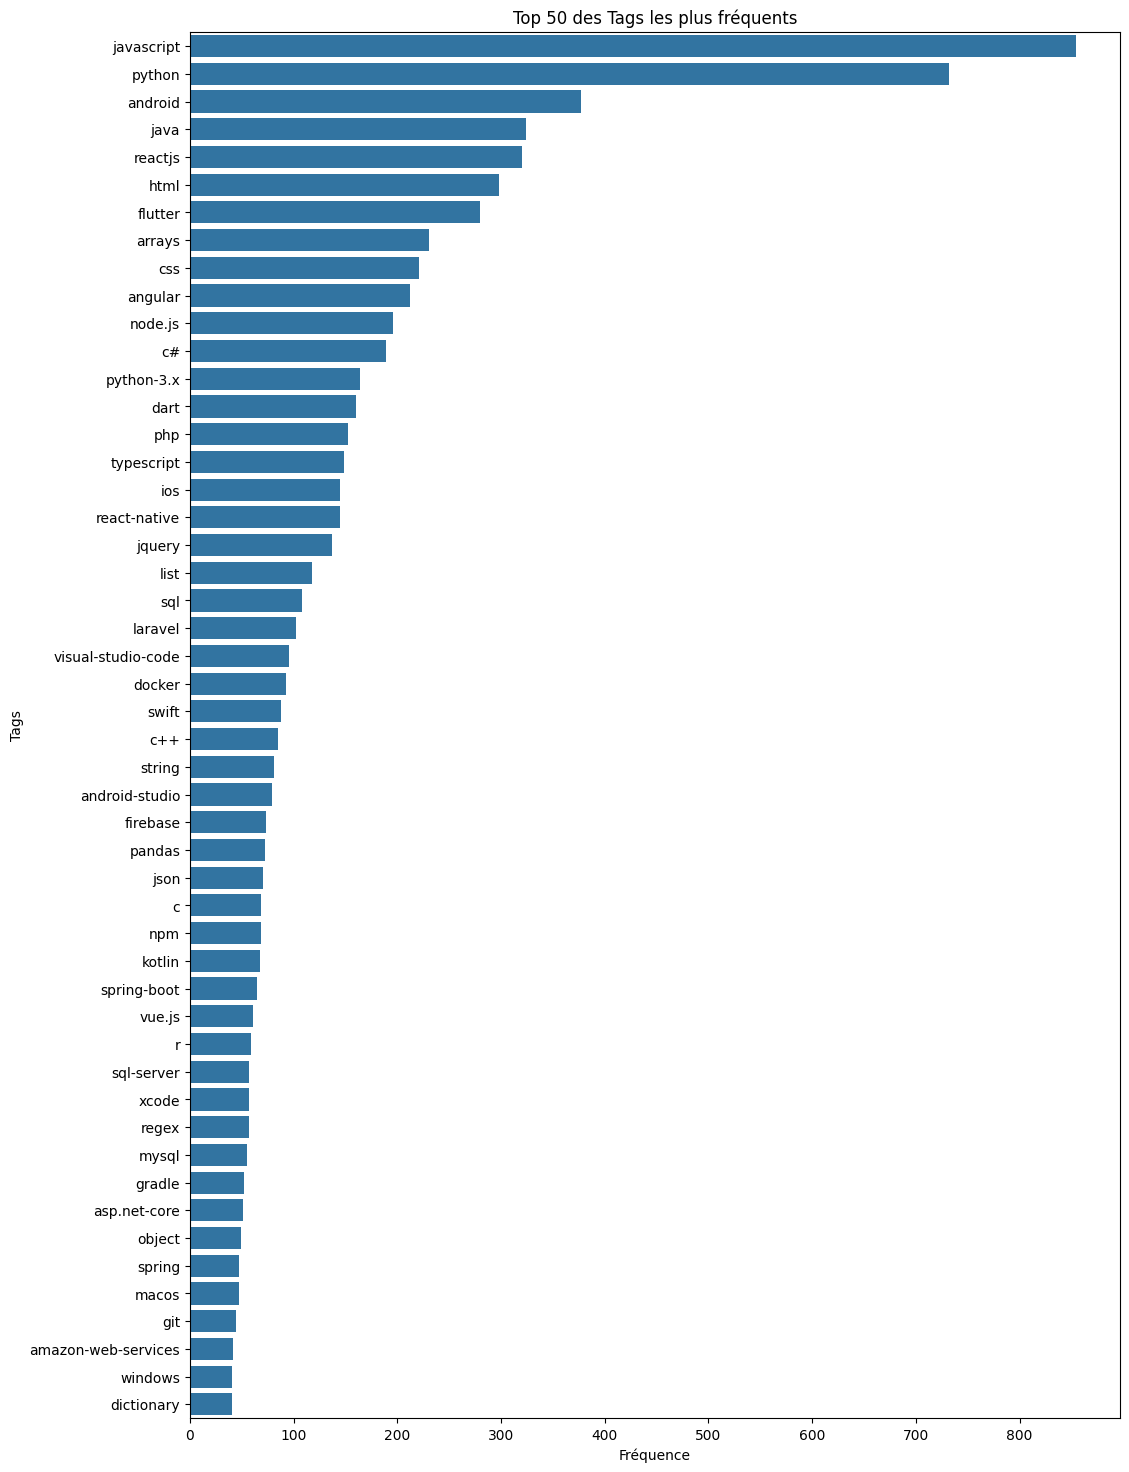

In [58]:
# Une liste des tags présents dans le DataFrame
all_tags = [tag for tags in df['Tags'] for tag in tags]

if all_tags:
    # Si oui, affiche le nombre total de tags extraits
    print(f"Nombre total de tags extraits: {len(all_tags)}")
else:
    print("Erreur : Aucun tag n'a été extrait")

# Compte la fréquence de chaque tag et sélectionne les 50 tags les plus fréquents
tag_counts = pd.Series(all_tags).value_counts().head(50)

# Les convertie en une liste
top_tags = list(tag_counts.index)

# Filtre les questions pour ne conserver que celles avec les top 50 tags
df['Filtered_Tags'] = df['Tags'].apply(lambda tags: [tag for tag in tags if tag in top_tags])

# Supprime les questions sans tags dans le top 50
df = df[df['Filtered_Tags'].apply(lambda x: len(x) > 0)]

print(top_tags)
plt.figure(figsize=(12, 18))
sns.barplot(x=tag_counts.values, y=tag_counts.index)
plt.title('Top 50 des Tags les plus fréquents')
plt.xlabel('Fréquence')
plt.ylabel('Tags')
plt.show()


In [102]:
import re

# Supprime balises HTML, caractères spéciaux, emojis, chiffres, mots de moins de 2 caractères
def clean_text(text):
    if isinstance(text, str):
        # Supprime les caractères spéciaux (non alphanumériques et non espaces)
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        # Supprime les emojis
        text = re.sub(r'[^\w\s,]', '', text)
        # Supprime les chiffres
        text = re.sub(r'\d+', '', text)
        # Supprime les mots à - de 2 caractères
        text = ' '.join([word for word in text.split() if len(word) > 2])
        # Supprime les balises HTML (y compris les balises mal formatées)
        text = re.sub(r'<[^>]+>', '', text)
    return text

# Applique la colonne 'Title'
df['Cleaned_Title'] = df['Title'].apply(clean_text)

# Applique la fonction à la colonne 'Body'
df['Cleaned_Body'] = df['Body'].apply(clean_text)

# Vérifie le résultat
print(df[['Title', 'Cleaned_Title', 'Body', 'Cleaned_Body']].head())

# Vérifie les tags
print("Vérification des tags")
print(df['Tags'].head(10))

# Contenu nettoyé
print('cleaned body', df['Cleaned_Body'].values)

df.head(10)


                                                      Title  \
33553                      Convert PDF to .docx with Python   
9427    Unknown Option error from Babel in React-Native app   
199                              Not Found for an API route   
12447                             Remove emojis from string   
39489  Permission denied when installing npm modules in OSX   

                                           Cleaned_Title  \
33553                       Convert PDF docx with Python   
9427     Unknown Option error from Babel ReactNative app   
199                              Not Found for API route   
12447                          Remove emojis from string   
39489  Permission denied when installing npm modules OSX   

                                                                                                                                                                                                                                                                    

Title  \
33553                                                                   Convert PDF to .docx with Python   
9427                                                 Unknown Option error from Babel in React-Native app   
199                                                                           Not Found for an API route   
12447                                                                          Remove emojis from string   
39489                                               Permission denied when installing npm modules in OSX   
42724                                                                  Using room as singleton in kotlin   
10822                                                          Angular 9 Application Not running on IE11   
49498  Can't create a SSISDB catalog due to missing SSISDBBackup.bak file, even though SSIS is installed   
4144                                                            Lombok not generating getter and setter?   
36958                                       google place autocomplete activity close automatic instantly   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

In [60]:
def add_features(df):
    # Longueur du titre
    df['Title_length'] = df['Title'].apply(
        lambda x: len(x.split()) if isinstance(x, str) else 0)
    # Nombre de mots dans le corps
    df['Body_word_count'] = df['Body'].apply(
        lambda x: len(x.split()) if isinstance(x, str) else 0)
    # Nombre de tags
    df['Tag_count'] = df['Tags'].apply(
        lambda x: len(x) if isinstance(x, list) else 0)
    return df


# Ajoute les features supplémentaires
df = add_features(df)
print(df.head(10))

                                                                                                   Title  \
33553                                                                   Convert PDF to .docx with Python   
9427                                                 Unknown Option error from Babel in React-Native app   
199                                                                           Not Found for an API route   
12447                                                                          Remove emojis from string   
39489                                               Permission denied when installing npm modules in OSX   
42724                                                                  Using room as singleton in kotlin   
10822                                                          Angular 9 Application Not running on IE11   
49498  Can't create a SSISDB catalog due to missing SSISDBBackup.bak file, even though SSIS is installed   
4144                        

In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4419 entries, 33553 to 20382
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Title            4419 non-null   object 
 1   Body             4419 non-null   object 
 2   Tags             4419 non-null   object 
 3   Id               4419 non-null   int64  
 4   Score            4419 non-null   int64  
 5   ViewCount        4419 non-null   int64  
 6   FavoriteCount    2728 non-null   float64
 7   AnswerCount      4419 non-null   int64  
 8   CreationDate     4419 non-null   object 
 9   Filtered_Tags    4419 non-null   object 
 10  Cleaned_Title    4419 non-null   object 
 11  Cleaned_Body     4419 non-null   object 
 12  Title_length     4419 non-null   int64  
 13  Body_word_count  4419 non-null   int64  
 14  Tag_count        4419 non-null   int64  
dtypes: float64(1), int64(7), object(7)
memory usage: 552.4+ KB


In [62]:
df = df.drop(columns=['FavoriteCount'])

## Analyse multivariée


In [63]:
cols_to_analyze = ['Score', 'ViewCount', 'AnswerCount',
                   'Title_length', 'Body_word_count', 'Tag_count']
score_col = 'Score'
view_col = 'ViewCount'
favorite_col = 'FavoriteCount'

Analyse Univariée


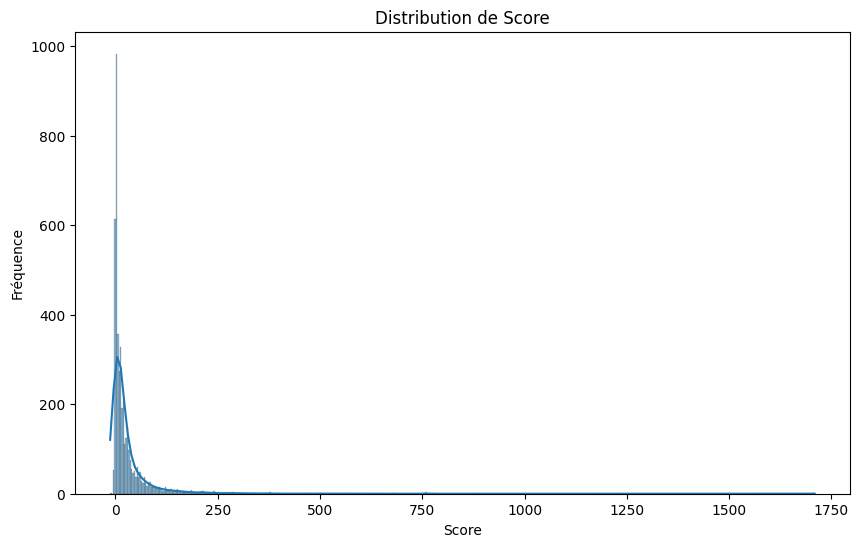

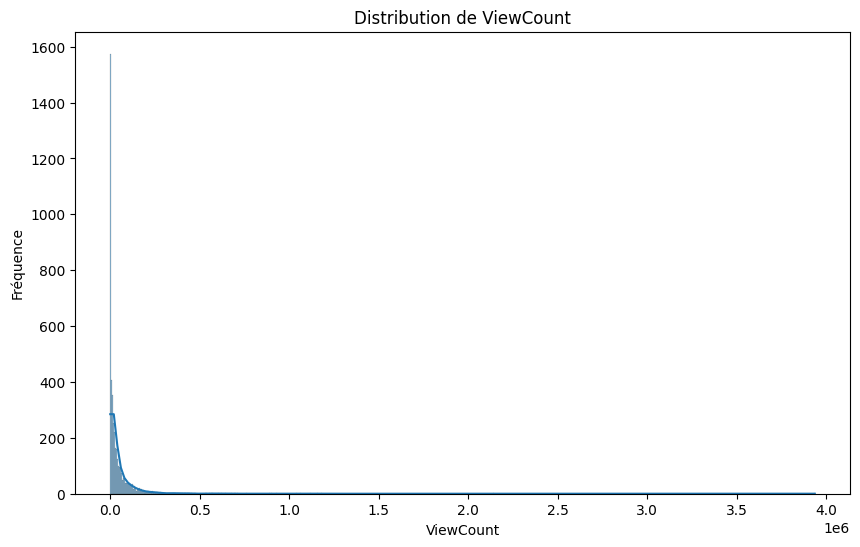

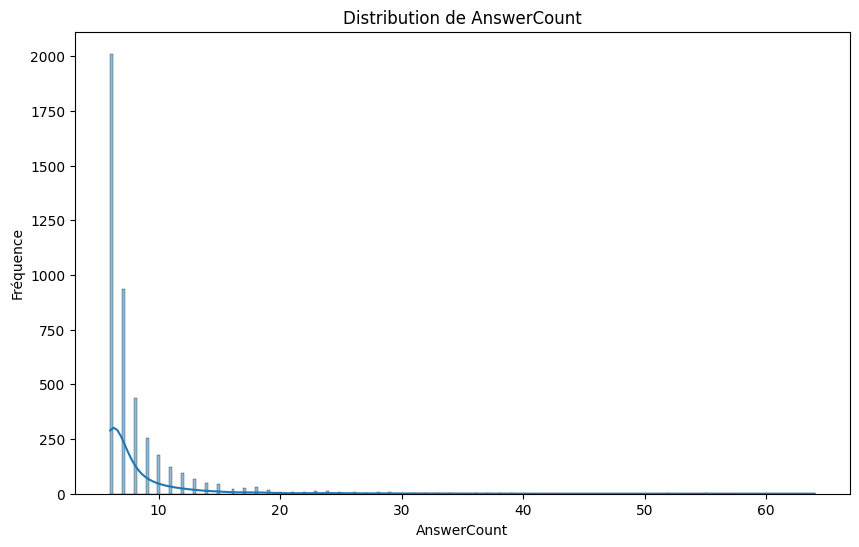

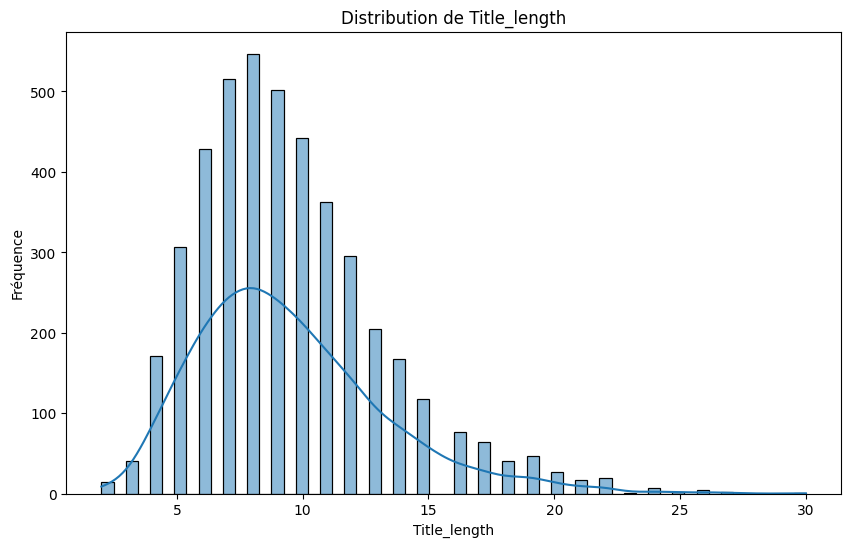

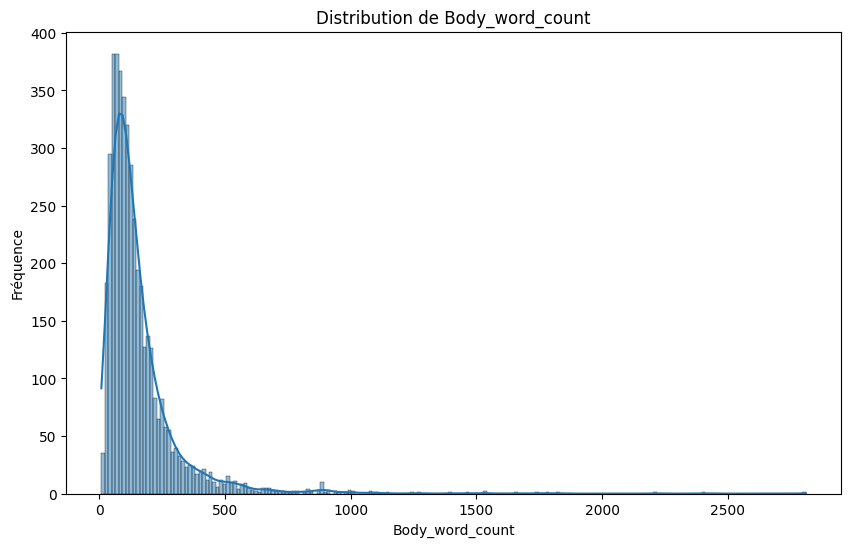

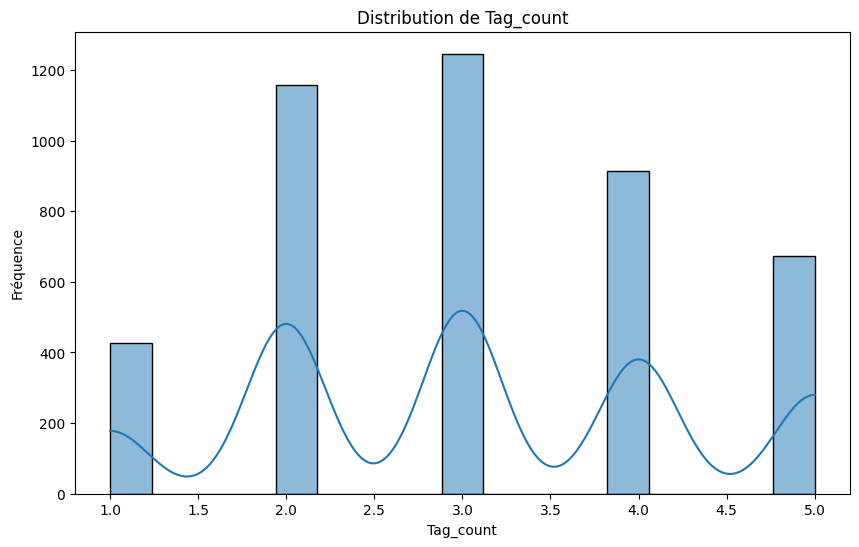

Analyse Multivariée


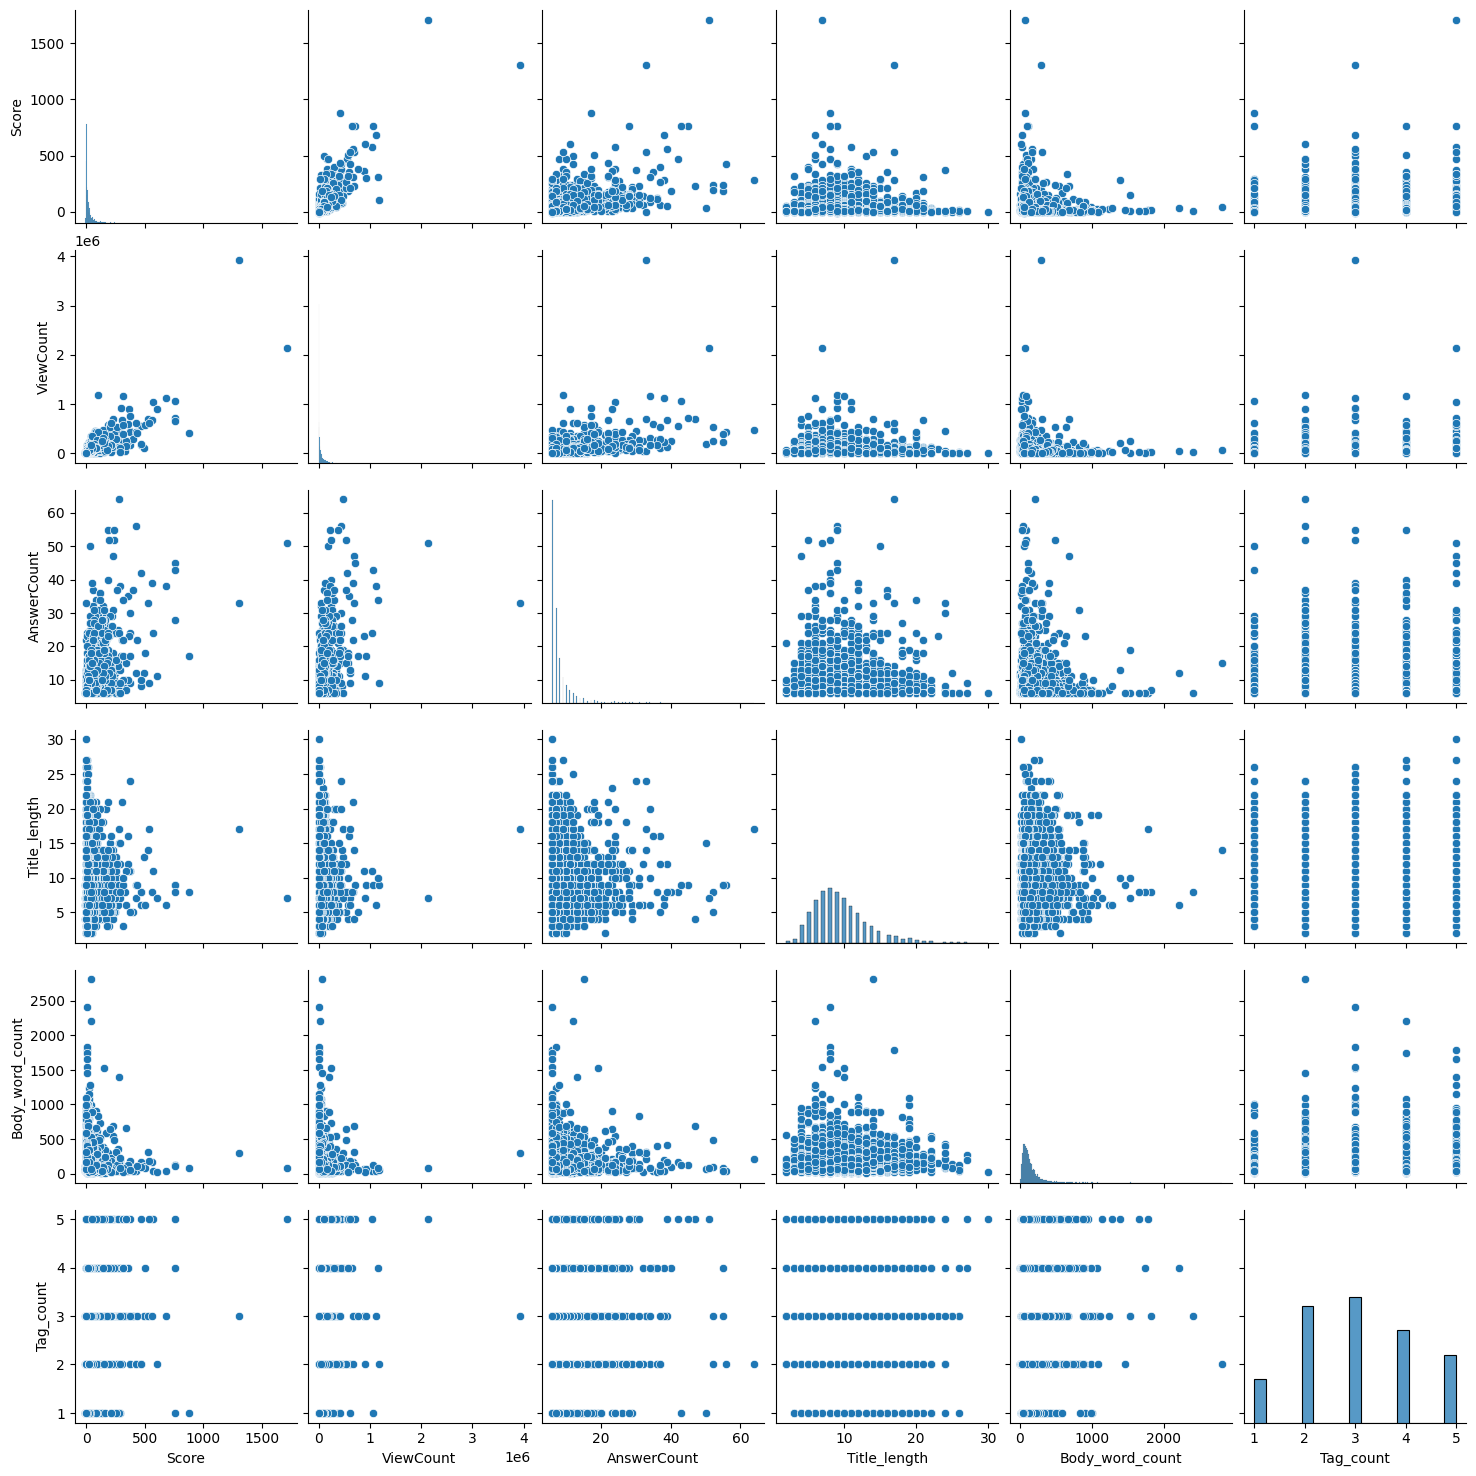

In [64]:
def analyse_univariee_multivariee(df, cols):
    print("Analyse Univariée")
    for column in cols:
        if column in df.columns:
            plt.figure(figsize=(10, 6))
            sns.histplot(df[column], kde=True)
            plt.title(f'Distribution de {column}')
            plt.xlabel(column)
            plt.ylabel('Fréquence')
            plt.show()

    print("Analyse Multivariée")
    sns.pairplot(df[cols].select_dtypes(include=['int64', 'float64']))
    plt.show()


analyse_univariee_multivariee(df, cols_to_analyze)

In [65]:
print(df.describe())

                 Id        Score     ViewCount  AnswerCount  Title_length  \
count  4.419000e+03  4419.000000  4.419000e+03  4419.000000   4419.000000   
mean   5.533332e+07    28.731840  4.344721e+04     8.178095      9.458248   
std    8.661653e+06    65.745337  1.066732e+05     4.500763      3.755878   
min    4.314564e+07   -13.000000  4.100000e+01     6.000000      2.000000   
25%    4.822993e+07     2.000000  1.880000e+03     6.000000      7.000000   
50%    5.370686e+07    10.000000  1.446400e+04     7.000000      9.000000   
75%    6.086880e+07    30.000000  4.673650e+04     8.000000     11.000000   
max    7.849482e+07  1709.000000  3.936259e+06    64.000000     30.000000   

       Body_word_count    Tag_count  
count      4419.000000  4419.000000  
mean        157.904051     3.056121  
std         161.550401     1.209409  
min           9.000000     1.000000  
25%          73.000000     2.000000  
50%         115.000000     3.000000  
75%         186.500000     4.000000  
ma

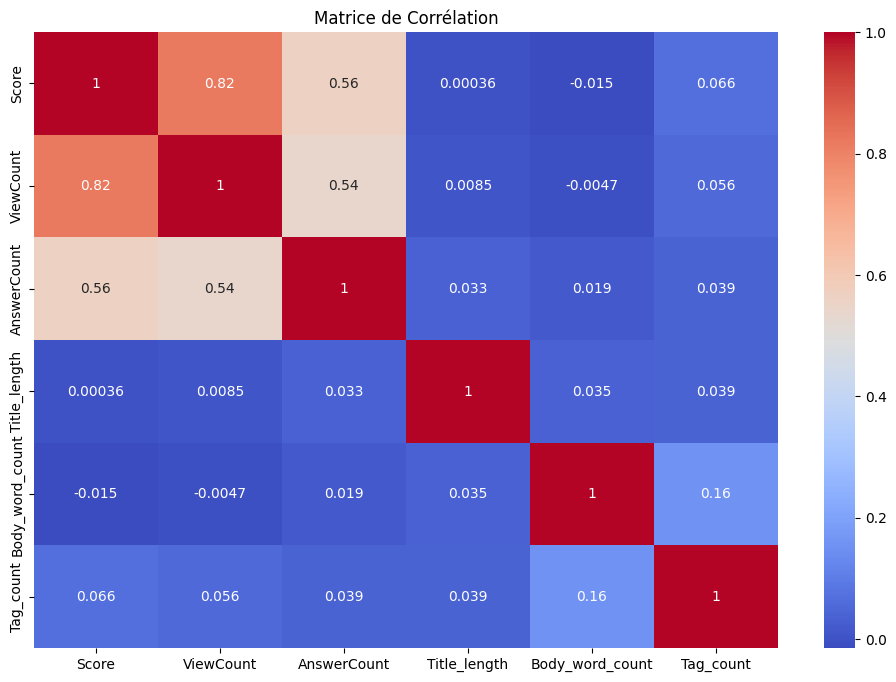

In [67]:
def correlation_variables(df, cols):
    corr_matrix = df[cols].corr()
    plt.figure(figsize=(12, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
    plt.title('Matrice de Corrélation')
    return corr_matrix

# Utilisation avec suivi MLflow
with mlflow.start_run(run_name="Correlation Analysis", nested=True):
    # Paramètres logués
    mlflow.log_param("analyzed_columns", cols_to_analyze)

    # Calcul et visualisation de la matrice de corrélation
    corr_matrix = correlation_variables(df, cols_to_analyze)

    # Sauvegarde et log du graphique de la matrice de corrélation
    corr_matrix_plot_path = "correlation_matrix.png"
    plt.savefig(corr_matrix_plot_path)
    mlflow.log_artifact(corr_matrix_plot_path)

    # Calcul et log de la métrique de corrélation moyenne
    mean_corr = corr_matrix.mean().mean()
    mlflow.log_metric("mean_correlation", mean_corr)

mlflow.end_run()


### Tokenization + stopwords + lemmatization

In [100]:
def treatments_text(text, remove_stopwords=True, lemmatize=True):
    # Tokenization
    tokens = word_tokenize(text)

    if remove_stopwords:
        # Suppression des stop words
        stop_words = set(stopwords.words('english'))
        tokens = [word for word in tokens if word.lower() not in stop_words]

    if lemmatize:
        # Lemmatization
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return ' '.join(tokens)

# Nettoyage du DataFrame
def clean_dataframe(df, remove_stopwords=True, lemmatize=True):
    df['Cleaned_Title'] = df['Title'].apply(lambda x: treatments_text(x, remove_stopwords, lemmatize))
    df['Cleaned_Body'] = df['Body'].apply(lambda x: treatments_text(x, remove_stopwords, lemmatize))
    return df

# Suivi MLflow
with mlflow.start_run(run_name="Text Cleaning", nested=True):
    # Paramètres de nettoyage
    remove_stopwords = True
    lemmatize = True
    
    # Log des paramètres
    mlflow.log_param("remove_stopwords", remove_stopwords)
    mlflow.log_param("lemmatize", lemmatize)

    # Nettoyage du DataFrame
    df = clean_dataframe(df, remove_stopwords=remove_stopwords, lemmatize=lemmatize)

    # Log d'un échantillon des données nettoyées
    sample_cleaned = df[['Title', 'Cleaned_Title', 'Body', 'Cleaned_Body']].head(10)
    sample_cleaned_path = "cleaned_data_sample.csv"
    sample_cleaned.to_csv(sample_cleaned_path, index=False)
    mlflow.log_artifact(sample_cleaned_path)

print(df[['Title', 'Cleaned_Title', 'Body', 'Cleaned_Body']].head())
print('clean', df[['Cleaned_Body']].values)
mlflow.end_run()


                                                      Title  \
33553                      Convert PDF to .docx with Python   
9427    Unknown Option error from Babel in React-Native app   
199                              Not Found for an API route   
12447                             Remove emojis from string   
39489  Permission denied when installing npm modules in OSX   

                                     Cleaned_Title  \
33553                     Convert PDF .docx Python   
9427   Unknown Option error Babel React-Native app   
199                                Found API route   
12447                         Remove emojis string   
39489  Permission denied installing npm module OSX   

                                                                                                                                                                                                                                                                                                        

### Différentes méthodes pour traiter les mots

In [69]:
def transform_text_to_bow(df, max_df=0.95, min_df=2, n_components=100):
    if 'Cleaned_Body' not in df.columns:
        raise ValueError("La colonne 'Cleaned_Body' est manquante dans le DataFrame")
    
    # Bag of Words : compte les mots et les représente en format numérique reflétant leur nombre
    vectorizer = CountVectorizer(max_df=max_df, min_df=min_df)
    X = vectorizer.fit_transform(df['Cleaned_Body'])

    # Réduction de dimension avec TruncatedSVD : réduit la dimensionnalité des vecteurs BoW
    svd = TruncatedSVD(n_components=n_components)
    X_reduced = svd.fit_transform(X)

    # Transformation des tags : convertit les tags en une forme utilisable pour l'apprentissage supervisé
    mlb = MultiLabelBinarizer(classes=top_tags)
    y = mlb.fit_transform(df['Filtered_Tags'])

    return X_reduced, y, vectorizer, svd, mlb

# Utilisation de la fonction avec suivi MLflow
with mlflow.start_run(run_name="BoW Transformation", nested=True):
    # Paramètres de transformation
    max_df = 0.95
    min_df = 2
    n_components = 100
    
    # Log des paramètres
    mlflow.log_param("max_df", max_df)
    mlflow.log_param("min_df", min_df)
    mlflow.log_param("n_components", n_components)

    # Transformation du texte
    X_reduced, y, vectorizer, svd, mlb = transform_text_to_bow(df, max_df=max_df, min_df=min_df, n_components=n_components)
    
    # Log des métriques
    explained_variance = svd.explained_variance_ratio_.sum()
    mlflow.log_metric("explained_variance", explained_variance)
    mlflow.log_metric("X_reduced_num_rows", X_reduced.shape[0])  # Nombre de lignes
    mlflow.log_metric("X_reduced_num_columns", X_reduced.shape[1])  # Nombre de colonnes
    mlflow.log_metric("y_num_rows", y.shape[0])  # Nombre de lignes
    mlflow.log_metric("y_num_columns", y.shape[1])  # Nombre de colonnes

    # Enregistrement des objets comme artefacts
    vectorizer_path = "model/vectorizer.pkl"
    svd_path = "model/svd.pkl"
    mlb_path = "model/mlb.pkl"
    
    with open(vectorizer_path, 'wb') as f:
        pickle.dump(vectorizer, f)
    with open(svd_path, 'wb') as f:
        pickle.dump(svd, f)
    with open(mlb_path, 'wb') as f:
        pickle.dump(mlb, f)
    
    mlflow.log_artifact(vectorizer_path)
    mlflow.log_artifact(svd_path)
    mlflow.log_artifact(mlb_path)

mlflow.end_run()


In [70]:
def train_word2vec(df, column='Cleaned_Body', vector_size=50, window=5, min_count=3, workers=4):
     # Tokenize les textes dans la colonne spécifiée (par défaut 'Cleaned_Body')
    sentences = df[column].apply(word_tokenize).tolist() # Chaque texte est transformé en une liste de mots

    word2vec_model = Word2Vec(sentences, vector_size=vector_size, window=window, min_count=min_count, workers=workers)
    
    def document_vector(doc):
        doc = [word for word in doc if word in word2vec_model.wv.index_to_key]
        return np.mean(word2vec_model.wv[doc], axis=0) if doc else np.zeros(vector_size)
    
    df['word2vec_vector'] = df[column].apply(lambda x: document_vector(word_tokenize(x)))
    
    X_word2vec = np.vstack(df['word2vec_vector'].values)
    model_path = 'model/word2vec'
    word2vec_model.save(model_path)
    return X_word2vec, model_path

with mlflow.start_run(run_name="Word2Vec Training", nested=True):
    # Paramètres pour l'entraînement Word2Vec
    vector_size = 50
    window = 5
    min_count = 3
    workers = 4
    
    # Log des paramètres
    mlflow.log_param("vector_size", vector_size)
    mlflow.log_param("window", window)
    mlflow.log_param("min_count", min_count)
    mlflow.log_param("workers", workers)

    # Entraînement Word2Vec
    X_word2vec, model_path = train_word2vec(df, column='Cleaned_Body', vector_size=vector_size, window=window, min_count=min_count, workers=workers)
    
    # Log de la forme des vecteurs
    mlflow.log_metric("word2vec_num_rows", X_word2vec.shape[0])  # Nombre de lignes
    mlflow.log_metric("word2vec_num_columns", X_word2vec.shape[1])  # Nombre de colonnes

    # Calcul et log de la moyenne des longueurs des vecteurs
    vector_lengths = np.linalg.norm(X_word2vec, axis=1)
    mean_vector_length = np.mean(vector_lengths)
    mlflow.log_metric("mean_vector_length", mean_vector_length)
    
    # Sauvegarde du modèle Word2Vec avec MLflow
    mlflow.log_artifact(model_path, artifact_path="models/word2vec")

mlflow.end_run()


In [71]:
import tensorflow_hub as hub
import tensorflow as tf

# Charger le modèle USE directement
model_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
use_layer = hub.KerasLayer(model_url, dtype=tf.string, trainable=False)

# Fonction pour encapsuler l'appel à la couche USE
def embed_texts(texts):
    return use_layer(texts)

# Test de la fonction sur des données d'exemple
texts = ["Sample text for embedding", "Another sample text"]
embeddings = embed_texts(texts)

print(embeddings)  # Affiche les embeddings générés

# Sauvegarde du modèle en format SavedModel
saved_model_path = "saved_models/use_model"
tf.saved_model.save(use_layer, saved_model_path)

# Log du chemin du modèle sauvegardé avec MLflow
import mlflow
import mlflow.pyfunc

mlflow.log_param("model_url", model_url)
mlflow.log_artifact(saved_model_path, artifact_path="saved_models/use_model")

# Classe qui encapsule le modèle pour compatibilité avec mlflow.pyfunc
class USEModelWrapper(mlflow.pyfunc.PythonModel):

    def load_context(self, context):
        # Charger le modèle enregistré en SavedModel
        self.model = tf.saved_model.load(context.artifacts["use_model"])

    def predict(self, context, model_input):
        # Effectue une prédiction avec le modèle
        return self.model([model_input]).numpy().flatten()

# Enregistrement du modèle avec mlflow.pyfunc.log_model
with mlflow.start_run(run_name="USE Model Training", nested=True):
    mlflow.pyfunc.log_model(
        artifact_path="models/use_model",
        python_model=USEModelWrapper(),
        artifacts={"use_model": saved_model_path},
        registered_model_name="UniversalSentenceEncoder"
    )

mlflow.end_run()


tf.Tensor(
[[-0.00331703  0.0392467   0.05301369 ...  0.02566237  0.01541226
  -0.02229235]
 [-0.0599828  -0.04418462  0.01197457 ... -0.04511365 -0.04361785
   0.0256268 ]], shape=(2, 512), dtype=float32)
INFO:tensorflow:Assets written to: saved_models/use_model\assets


INFO:tensorflow:Assets written to: saved_models/use_model\assets
Registered model 'UniversalSentenceEncoder' already exists. Creating a new version of this model...
Created version '37' of model 'UniversalSentenceEncoder'.
2024/08/16 01:32:43 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


In [72]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import MultiLabelBinarizer
import mlflow
import mlflow.keras 
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec
import numpy as np
import tensorflow_hub as hub
import mlflow.pyfunc
import os
import tensorflow as tf
import pickle


In [73]:

mlflow.set_experiment("Text_Processing_Experiment")




<Experiment: artifact_location='file:///c:/Users/leenc/Documents/openclassrooms/p5/notebooks/mlruns/513811231573427600', creation_time=1722810345955, experiment_id='513811231573427600', last_update_time=1722810485632, lifecycle_stage='active', name='Text_Processing_Experiment', tags={}>

In [74]:
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [75]:
df = pd.read_csv('db/questions_db.csv')
print(df.head())
# pour réduire l'échantillon si nécessaire
df = df.sample(frac=0.1, random_state=42) 


                                                                                              Title  \
0                           C++ function template specialization based on the templated return type   
1                                                  How can I write a std::apply on a std::expected?   
2  App must target Android 14 (API level 34) or higher is showing even after update to API level 34   
3                        Efficiently find the number of different classmates from course-level data   
4                               Get the first and last number occuring in a (text) string in a cell   

                                                                                                                                                                                                                                                                                                                                                                                             

In [76]:
mlflow.start_run(run_name="Full Pipeline")

# Logue les paramètres globaux
mlflow.log_param("data_sample_fraction", 0.1)
mlflow.log_param("num_samples", len(df))
mlflow.log_param("num_features", df.shape[1])


9

In [77]:

# transforme les tags sous forme de chaîne de caractères en liste
def process_tags(tags):
    if isinstance(tags, str):
        
        # Enlève les symboles '<>' entourant les tags et les divise en une liste
        return tags.strip('<>').split('><')
    else:
        return []
    

# Applique le traitement des tags à la colonne 'Tags' du DataFrame
df['Tags'] = df['Tags'].apply(process_tags)

In [78]:

# Vérifie les valeurs manquantes
def check_missing_values(df):
    missing_values = df.isnull().sum()
    print("Nombre de valeurs manquantes par colonne:")
    print(missing_values)
    if missing_values.any():
        print("\nColonnes avec valeurs manquantes:")
        print(missing_values[missing_values > 0])
    else:
        print("Aucune valeur manquante trouvée.")


check_missing_values(df)

Nombre de valeurs manquantes par colonne:
Title               0
Body                0
Tags                0
Id                  0
Score               0
ViewCount           0
FavoriteCount    1852
AnswerCount         0
CreationDate        0
dtype: int64

Colonnes avec valeurs manquantes:
FavoriteCount    1852
dtype: int64


Nombre total de tags extraits: 14944
['javascript', 'python', 'android', 'java', 'reactjs', 'html', 'flutter', 'arrays', 'css', 'angular', 'node.js', 'c#', 'python-3.x', 'dart', 'php', 'typescript', 'ios', 'react-native', 'jquery', 'list', 'sql', 'laravel', 'visual-studio-code', 'docker', 'swift', 'c++', 'string', 'android-studio', 'firebase', 'pandas', 'json', 'c', 'npm', 'kotlin', 'spring-boot', 'vue.js', 'r', 'sql-server', 'xcode', 'regex', 'mysql', 'gradle', 'asp.net-core', 'object', 'spring', 'macos', 'git', 'amazon-web-services', 'windows', 'dictionary']


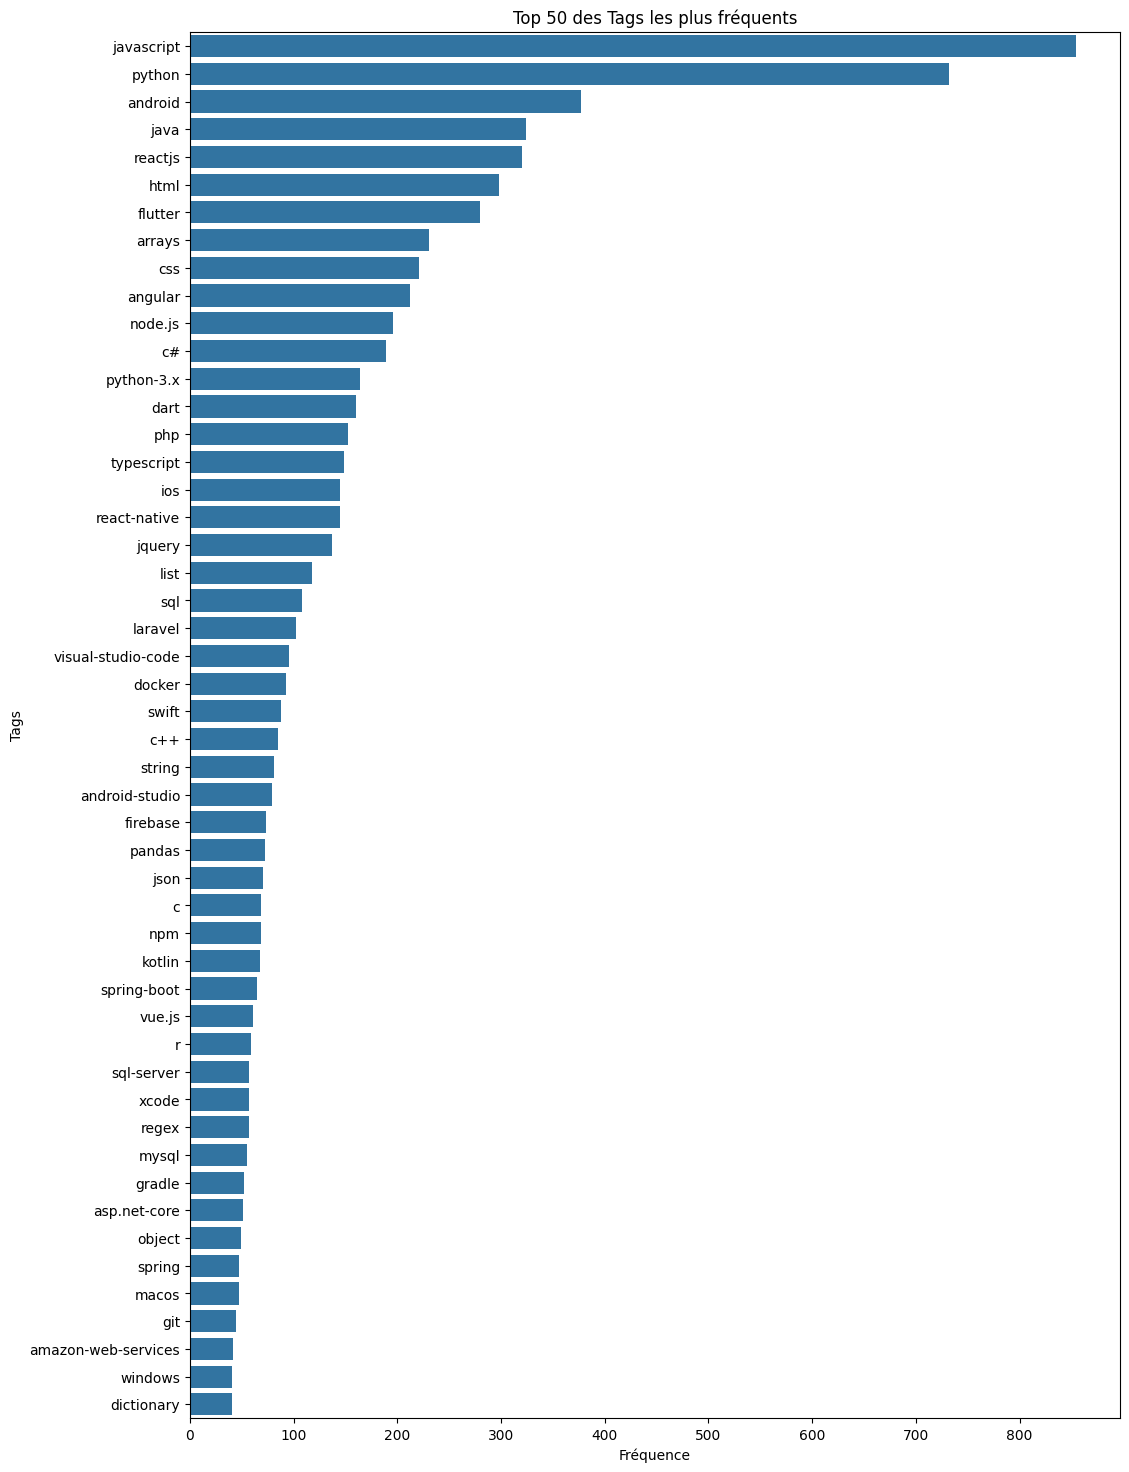

In [79]:
# Crée une liste des tags présents dans le DataFrame
all_tags = [tag for tags in df['Tags'] for tag in tags]

if all_tags:
    # Si oui, affiche le nombre total de tags extraits
    print(f"Nombre total de tags extraits: {len(all_tags)}")
else:
    print("Erreur : Aucun tag n'a été extrait")

# Compte la fréquence de chaque tag et sélectionne les 50 tags les plus fréquents
tag_counts = pd.Series(all_tags).value_counts().head(50)

# Les convertie en une liste
top_tags = list(tag_counts.index)

# Filtre les questions pour ne conserver que celles avec les top 50 tags
df['Filtered_Tags'] = df['Tags'].apply(lambda tags: [tag for tag in tags if tag in top_tags])

# Supprime les questions sans tags dans le top 50
df = df[df['Filtered_Tags'].apply(lambda x: len(x) > 0)]

print(top_tags)
plt.figure(figsize=(12, 18))
sns.barplot(x=tag_counts.values, y=tag_counts.index)
plt.title('Top 50 des Tags les plus fréquents')
plt.xlabel('Fréquence')
plt.ylabel('Tags')
plt.show()


In [80]:
# vérifie la présence de balises HTML et de caractères spéciaux dans un texte
def check_html_special_chars(text):
    if isinstance(text, str):
        # Trouve toutes les balises HTML dans le texte
        html_tags = re.findall(r'<.*?>', text)
        # Trouve tous les caractères spéciaux (non alphanumériques et non espaces) 
        special_chars = re.findall(r'[^a-zA-Z0-9\s]', text)
        # Retourne le nombre total de balises HTML et de caractères spéciaux trouvés
        return len(html_tags) + len(special_chars)
    return 0


# Applique check_html_special_chars à la colonne 'Title'
df['Title_html_special'] = df['Title'].apply(check_html_special_chars)
# Applique check_html_special_chars à la colonne 'Body'

df['Body_html_special'] = df['Body'].apply(check_html_special_chars)

print("Occurrences de caractères HTML ou spéciaux restants dans les titres")
print(df['Title_html_special'].value_counts())
print("Occurrences de caractères HTML ou spéciaux restants dans les corps")
print(df['Body_html_special'].value_counts())

# Vérification des tags
print("Vérification des tags")
print(df['Tags'].head(10))

# Affiche le tableau complet sans limite
print(df)

Occurrences de caractères HTML ou spéciaux restants dans les titres
Title_html_special
0     1573
1     1223
2      537
3      376
4      225
5      131
6      104
7       61
8       50
9       41
10      29
11      19
12      14
14       8
15       8
13       7
17       5
16       3
18       2
20       1
19       1
21       1
Name: count, dtype: int64
Occurrences de caractères HTML ou spéciaux restants dans les corps
Body_html_special
89      26
62      24
78      23
68      23
56      23
        ..
860      1
439      1
769      1
643      1
1289     1
Name: count, Length: 818, dtype: int64
Vérification des tags
33553                             [python, pdf, docx, libreoffice, doc]
9427     [javascript, typescript, react-native, babeljs, metro-bundler]
199                                               [javascript, next.js]
12447                                                      [php, emoji]
39489                                             [node.js, macos, npm]
42724             

In [81]:
def add_features(df):
    # Longueur du titre
    df['Title_length'] = df['Title'].apply(
        lambda x: len(x.split()) if isinstance(x, str) else 0)
    # Nombre de mots dans le corps
    df['Body_word_count'] = df['Body'].apply(
        lambda x: len(x.split()) if isinstance(x, str) else 0)
    # Nombre de tags
    df['Tag_count'] = df['Tags'].apply(
        lambda x: len(x) if isinstance(x, list) else 0)
    return df


# Ajoute les features supplémentaires
df = add_features(df)
print(df.head(10))

                                                                                                   Title  \
33553                                                                   Convert PDF to .docx with Python   
9427                                                 Unknown Option error from Babel in React-Native app   
199                                                                           Not Found for an API route   
12447                                                                          Remove emojis from string   
39489                                               Permission denied when installing npm modules in OSX   
42724                                                                  Using room as singleton in kotlin   
10822                                                          Angular 9 Application Not running on IE11   
49498  Can't create a SSISDB catalog due to missing SSISDBBackup.bak file, even though SSIS is installed   
4144                        

In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4419 entries, 33553 to 20382
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Title               4419 non-null   object 
 1   Body                4419 non-null   object 
 2   Tags                4419 non-null   object 
 3   Id                  4419 non-null   int64  
 4   Score               4419 non-null   int64  
 5   ViewCount           4419 non-null   int64  
 6   FavoriteCount       2728 non-null   float64
 7   AnswerCount         4419 non-null   int64  
 8   CreationDate        4419 non-null   object 
 9   Filtered_Tags       4419 non-null   object 
 10  Title_html_special  4419 non-null   int64  
 11  Body_html_special   4419 non-null   int64  
 12  Title_length        4419 non-null   int64  
 13  Body_word_count     4419 non-null   int64  
 14  Tag_count           4419 non-null   int64  
dtypes: float64(1), int64(9), object(5)
memory usage: 552.4+

In [83]:
df = df.drop(columns=['FavoriteCount'])

## Analyse multivariée


In [84]:
cols_to_analyze = ['Score', 'ViewCount', 'AnswerCount',
                   'Title_length', 'Body_word_count', 'Tag_count']
score_col = 'Score'
view_col = 'ViewCount'
favorite_col = 'FavoriteCount'

Analyse Univariée


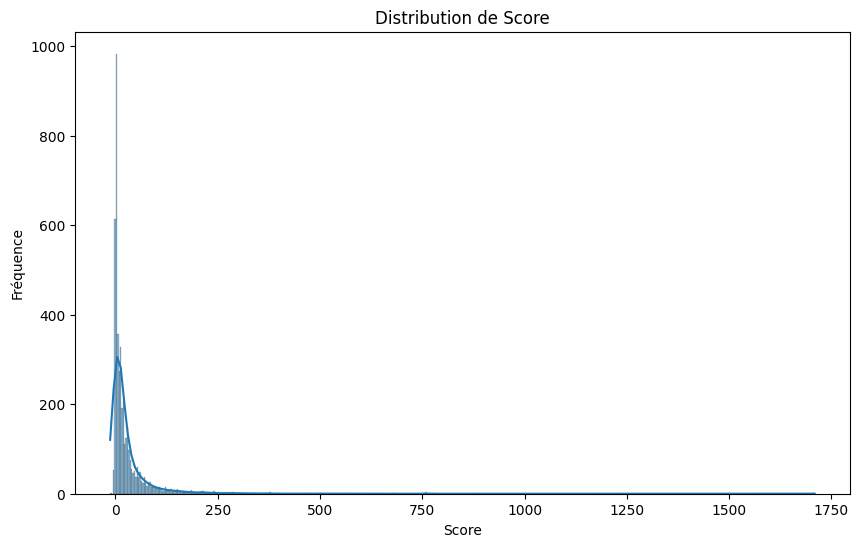

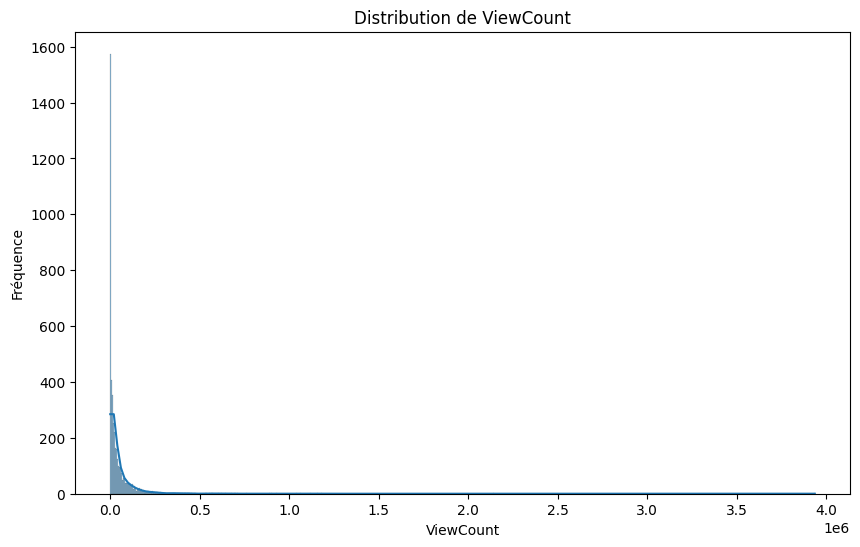

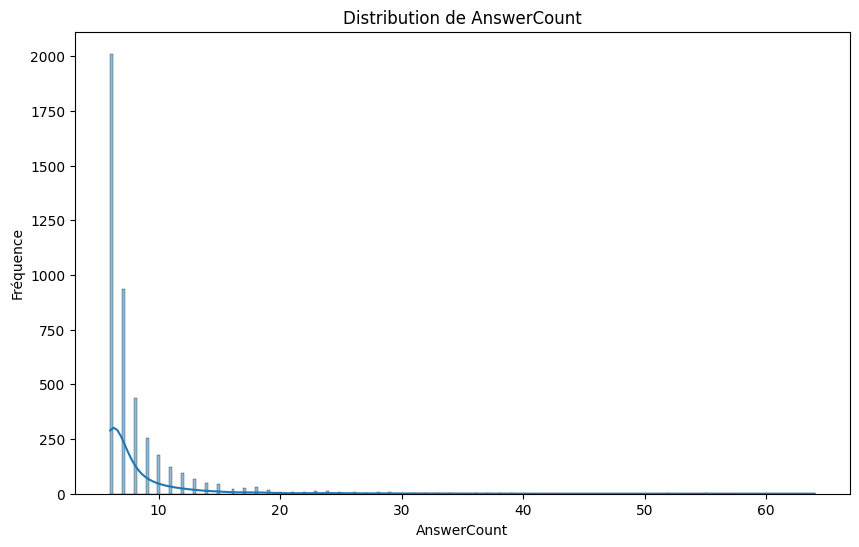

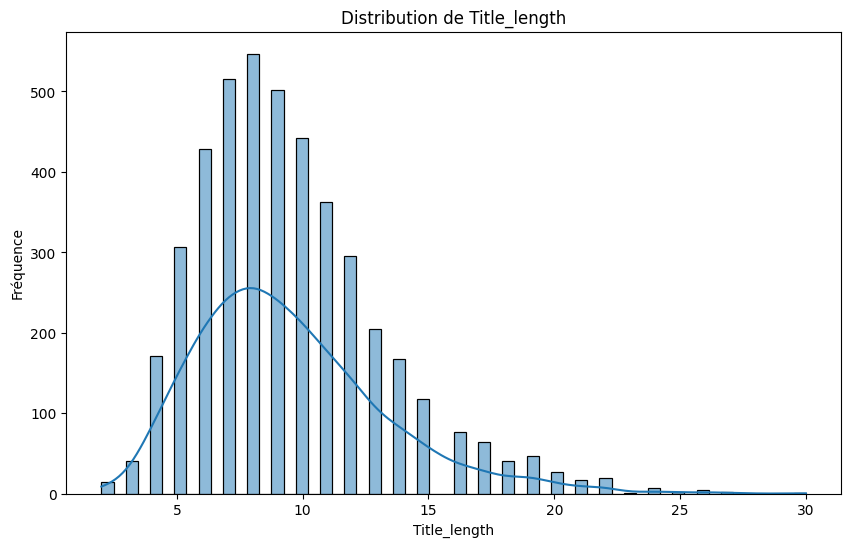

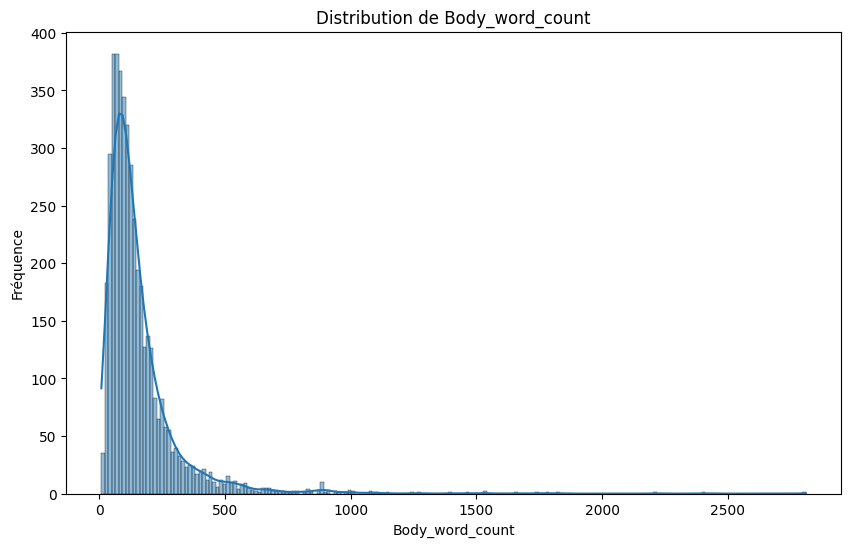

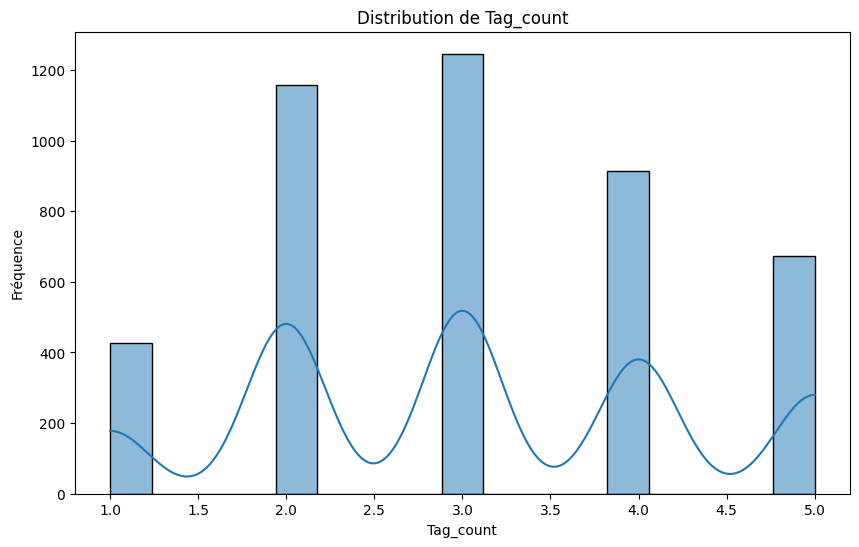

Analyse Multivariée


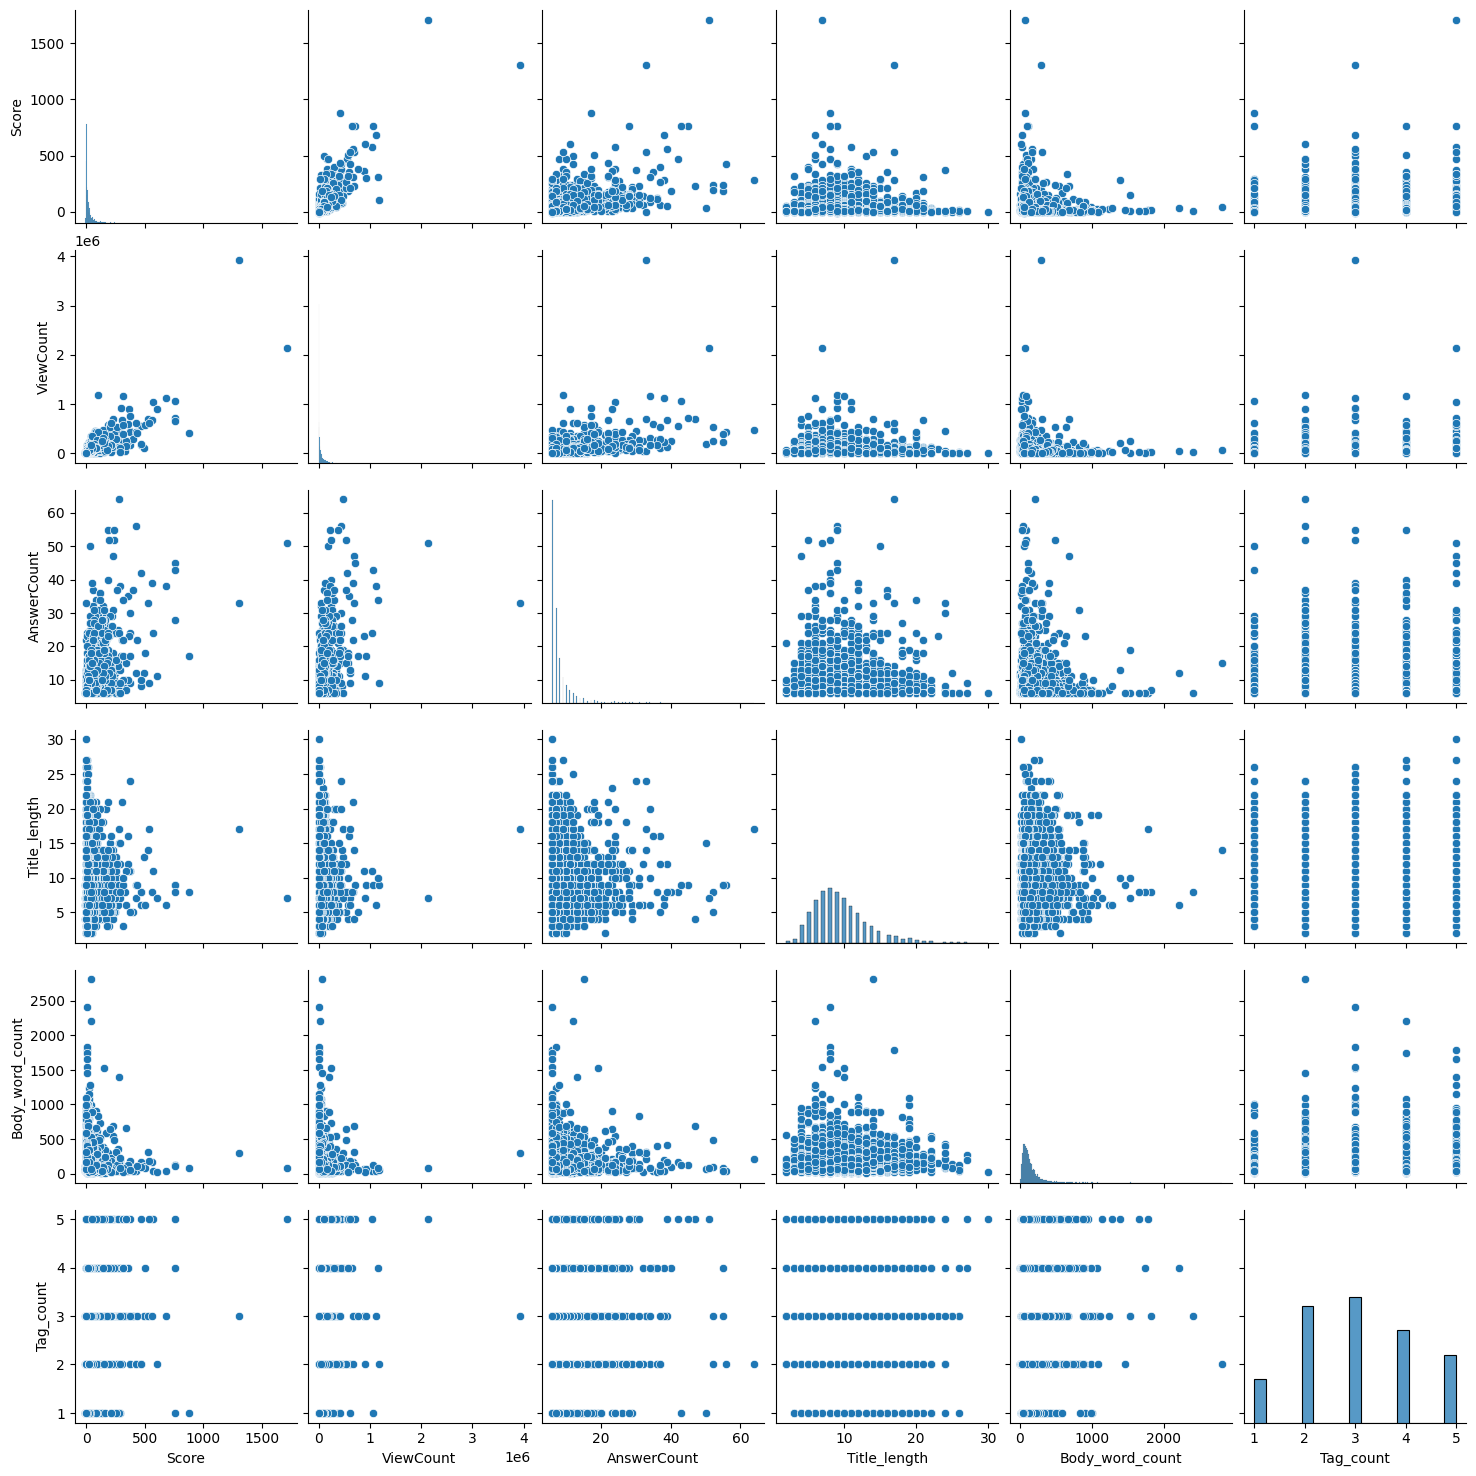

In [85]:
def analyse_univariee_multivariee(df, cols):
    print("Analyse Univariée")
    for column in cols:
        if column in df.columns:
            plt.figure(figsize=(10, 6))
            sns.histplot(df[column], kde=True)
            plt.title(f'Distribution de {column}')
            plt.xlabel(column)
            plt.ylabel('Fréquence')
            plt.show()

    print("Analyse Multivariée")
    sns.pairplot(df[cols].select_dtypes(include=['int64', 'float64']))
    plt.show()


analyse_univariee_multivariee(df, cols_to_analyze)

In [86]:
print(df.describe())

                 Id        Score     ViewCount  AnswerCount  \
count  4.419000e+03  4419.000000  4.419000e+03  4419.000000   
mean   5.533332e+07    28.731840  4.344721e+04     8.178095   
std    8.661653e+06    65.745337  1.066732e+05     4.500763   
min    4.314564e+07   -13.000000  4.100000e+01     6.000000   
25%    4.822993e+07     2.000000  1.880000e+03     6.000000   
50%    5.370686e+07    10.000000  1.446400e+04     7.000000   
75%    6.086880e+07    30.000000  4.673650e+04     8.000000   
max    7.849482e+07  1709.000000  3.936259e+06    64.000000   

       Title_html_special  Body_html_special  Title_length  Body_word_count  \
count         4419.000000        4419.000000   4419.000000      4419.000000   
mean             1.814664         255.617561      9.458248       157.904051   
std              2.524718         355.396832      3.755878       161.550401   
min              0.000000           8.000000      2.000000         9.000000   
25%              0.000000          91

In [87]:
def distribution_scores_vues_favoris(df, score_col, view_col, favorite_col):
    if score_col in df.columns:
        plt.figure(figsize=(10, 6))
        sns.histplot(df[score_col], bins=30, kde=True)
        plt.title(f'Distribution de {score_col}')
        plt.xlabel(score_col)
        plt.ylabel('Fréquence')
        plt.show()

    if view_col in df.columns:
        plt.figure(figsize=(10, 6))
        sns.histplot(df[view_col], bins=30, kde=True)
        plt.title(f'Distribution de {view_col}')
        plt.xlabel(view_col)
        plt.ylabel('Fréquence')
        plt.show()

    if favorite_col in df.columns and df[favorite_col].notnull().sum() > 0:
        plt.figure(figsize=(10, 6))
        sns.histplot(df[favorite_col], bins=30, kde=True)
        plt.title(f'Distribution de {favorite_col}')
        plt.xlabel(favorite_col)
        plt.ylabel('Fréquence')
        plt.show()
    else:
        print(f"La colonne {favorite_col} est vide ou n'existe pas.")

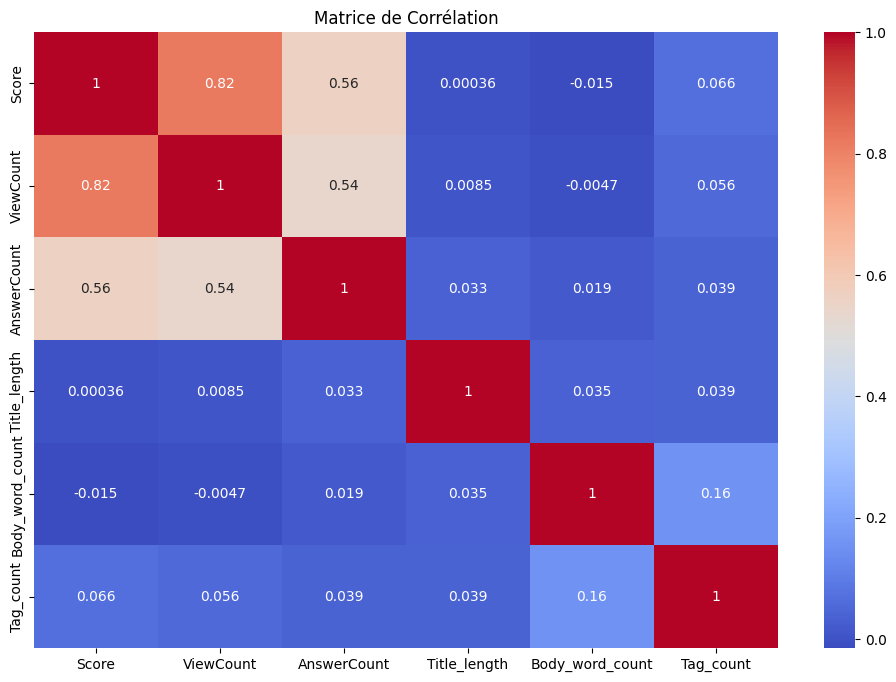

In [88]:
def correlation_variables(df, cols):
    corr_matrix = df[cols].corr()
    plt.figure(figsize=(12, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
    plt.title('Matrice de Corrélation')
    return corr_matrix

# Utilisation avec suivi MLflow
with mlflow.start_run(run_name="Correlation Analysis", nested=True):
    # Paramètres logués
    mlflow.log_param("analyzed_columns", cols_to_analyze)

    # Calcul et visualisation de la matrice de corrélation
    corr_matrix = correlation_variables(df, cols_to_analyze)

    # Sauvegarde et log du graphique de la matrice de corrélation
    corr_matrix_plot_path = "correlation_matrix.png"
    plt.savefig(corr_matrix_plot_path)
    mlflow.log_artifact(corr_matrix_plot_path)

    # Calcul et log de la métrique de corrélation moyenne
    mean_corr = corr_matrix.mean().mean()
    mlflow.log_metric("mean_correlation", mean_corr)

mlflow.end_run()


### Tokenization + stopwords + lemmatization

In [89]:
# Nettoie le texte


with mlflow.start_run(run_name="Text Cleaning", nested=True):
    # Paramètres de nettoyage
    remove_stopwords = True
    lemmatize = True
    
    # Log des paramètres
    mlflow.log_param("remove_stopwords", remove_stopwords)
    mlflow.log_param("lemmatize", lemmatize)

    # Nettoyage du DataFrame
    df = clean_dataframe(df, remove_stopwords=remove_stopwords, lemmatize=lemmatize)

    # Log d'un échantillon des données nettoyées
    sample_cleaned = df[['Title', 'Cleaned_Title', 'Body', 'Cleaned_Body']].head(10)
    sample_cleaned_path = "cleaned_data_sample.csv"
    sample_cleaned.to_csv(sample_cleaned_path, index=False)
    mlflow.log_artifact(sample_cleaned_path)

    # Calcul et log du nombre moyen de mots par document après nettoyage
    avg_words_per_doc = df['Cleaned_Body'].apply(lambda x: len(x.split())).mean()
    mlflow.log_metric("avg_words_per_doc", avg_words_per_doc)

    # Calcul et log de la proportion de documents vides après nettoyage
    num_empty_docs = df['Cleaned_Body'].apply(lambda x: len(x.strip()) == 0).sum()
    proportion_empty_docs = num_empty_docs / len(df)
    mlflow.log_metric("proportion_empty_docs", proportion_empty_docs)

mlflow.end_run()


print(df.head())

                                                      Title  \
33553                      Convert PDF to .docx with Python   
9427    Unknown Option error from Babel in React-Native app   
199                              Not Found for an API route   
12447                             Remove emojis from string   
39489  Permission denied when installing npm modules in OSX   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

In [90]:
def treatments_text(text, remove_stopwords=True, lemmatize=True):
    # Tokenization
    tokens = word_tokenize(text)

    if remove_stopwords:
        # Suppression des stop words
        stop_words = set(stopwords.words('english'))
        tokens = [word for word in tokens if word.lower() not in stop_words]

    if lemmatize:
        # Lemmatization
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return ' '.join(tokens)

# Nettoyage du DataFrame
def clean_dataframe(df, remove_stopwords=True, lemmatize=True):
    df['Cleaned_Title'] = df['Title'].apply(lambda x: treatments_text(x, remove_stopwords, lemmatize))
    df['Cleaned_Body'] = df['Body'].apply(lambda x: treatments_text(x, remove_stopwords, lemmatize))
    return df

# Suivi MLflow
with mlflow.start_run(run_name="Text Cleaning", nested=True):
    # Paramètres de nettoyage
    remove_stopwords = True
    lemmatize = True
    
    # Log des paramètres
    mlflow.log_param("remove_stopwords", remove_stopwords)
    mlflow.log_param("lemmatize", lemmatize)

    # Nettoyage du DataFrame
    df = clean_dataframe(df, remove_stopwords=remove_stopwords, lemmatize=lemmatize)

    # Log d'un échantillon des données nettoyées
    sample_cleaned = df[['Title', 'Cleaned_Title', 'Body', 'Cleaned_Body']].head(10)
    sample_cleaned_path = "cleaned_data_sample.csv"
    sample_cleaned.to_csv(sample_cleaned_path, index=False)
    mlflow.log_artifact(sample_cleaned_path)

print(df[['Title', 'Cleaned_Title', 'Body', 'Cleaned_Body']].head())

mlflow.end_run()


                                                      Title  \
33553                      Convert PDF to .docx with Python   
9427    Unknown Option error from Babel in React-Native app   
199                              Not Found for an API route   
12447                             Remove emojis from string   
39489  Permission denied when installing npm modules in OSX   

                                     Cleaned_Title  \
33553                     Convert PDF .docx Python   
9427   Unknown Option error Babel React-Native app   
199                                Found API route   
12447                         Remove emojis string   
39489  Permission denied installing npm module OSX   

                                                                                                                                                                                                                                                                                                        

### Différentes méthodes pour traiter les mots

In [91]:
def transform_text_to_bow(df, max_df=0.95, min_df=2, n_components=100):
    if 'Cleaned_Body' not in df.columns:
        raise ValueError("La colonne 'Cleaned_Body' est manquante dans le DataFrame")
    
    # Bag of Words : compte les mots et les représente en format numérique
    vectorizer = CountVectorizer(max_df=max_df, min_df=min_df)
    X = vectorizer.fit_transform(df['Cleaned_Body'])

    # Réduction de dimension avec TruncatedSVD : réduit la dimensionnalité des vecteurs BoW
    svd = TruncatedSVD(n_components=n_components)
    X_reduced = svd.fit_transform(X)

    # Transformation des tags : convertit les tags en une forme utilisable pour l'apprentissage supervisé
    mlb = MultiLabelBinarizer(classes=top_tags)
    y = mlb.fit_transform(df['Filtered_Tags'])

    return X_reduced, y, vectorizer, svd, mlb

# Utilisation de la fonction avec suivi MLflow
with mlflow.start_run(run_name="BoW Transformation", nested=True):
    # Paramètres de transformation
    max_df = 0.95
    min_df = 2
    n_components = 100
    
    # Log des paramètres
    mlflow.log_param("max_df", max_df)
    mlflow.log_param("min_df", min_df)
    mlflow.log_param("n_components", n_components)

    # Transformation du texte
    X_reduced, y, vectorizer, svd, mlb = transform_text_to_bow(df, max_df=max_df, min_df=min_df, n_components=n_components)
    
    # Log des métriques
    explained_variance = svd.explained_variance_ratio_.sum()
    mlflow.log_metric("explained_variance", explained_variance)
    mlflow.log_metric("X_reduced_num_rows", X_reduced.shape[0])  # Nombre de lignes
    mlflow.log_metric("X_reduced_num_columns", X_reduced.shape[1])  # Nombre de colonnes
    mlflow.log_metric("y_num_rows", y.shape[0])  # Nombre de lignes
    mlflow.log_metric("y_num_columns", y.shape[1])  # Nombre de colonnes

    # Enregistrement des objets comme artefacts
    vectorizer_path = "model/vectorizer.pkl"
    svd_path = "model/svd.pkl"
    mlb_path = "model/mlb.pkl"
    
    with open(vectorizer_path, 'wb') as f:
        pickle.dump(vectorizer, f)
    with open(svd_path, 'wb') as f:
        pickle.dump(svd, f)
    with open(mlb_path, 'wb') as f:
        pickle.dump(mlb, f)
    
    mlflow.log_artifact(vectorizer_path)
    mlflow.log_artifact(svd_path)
    mlflow.log_artifact(mlb_path)

mlflow.end_run()


In [92]:
def train_word2vec(df, column='Cleaned_Body', vector_size=50, window=5, min_count=3, workers=4):
    sentences = df[column].apply(word_tokenize).tolist()
    word2vec_model = Word2Vec(sentences, vector_size=vector_size, window=window, min_count=min_count, workers=workers)
    
    def document_vector(doc):
        doc = [word for word in doc if word in word2vec_model.wv.index_to_key]
        return np.mean(word2vec_model.wv[doc], axis=0) if doc else np.zeros(vector_size)
    
    df['word2vec_vector'] = df[column].apply(lambda x: document_vector(word_tokenize(x)))
    
    X_word2vec = np.vstack(df['word2vec_vector'].values)
    model_path = 'model/word2vec'
    word2vec_model.save(model_path)
    return X_word2vec, model_path

with mlflow.start_run(run_name="Word2Vec Training", nested=True):
    # Paramètres pour l'entraînement Word2Vec
    vector_size = 50
    window = 5
    min_count = 3
    workers = 4
    
    # Log des paramètres
    mlflow.log_param("vector_size", vector_size)
    mlflow.log_param("window", window)
    mlflow.log_param("min_count", min_count)
    mlflow.log_param("workers", workers)

    # Entraînement Word2Vec
    X_word2vec, model_path = train_word2vec(df, column='Cleaned_Body', vector_size=vector_size, window=window, min_count=min_count, workers=workers)
    
    # Log de la forme des vecteurs
    mlflow.log_metric("word2vec_num_rows", X_word2vec.shape[0])  # Nombre de lignes
    mlflow.log_metric("word2vec_num_columns", X_word2vec.shape[1])  # Nombre de colonnes

    # Calcul et log de la moyenne des longueurs des vecteurs
    vector_lengths = np.linalg.norm(X_word2vec, axis=1)
    mean_vector_length = np.mean(vector_lengths)
    mlflow.log_metric("mean_vector_length", mean_vector_length)
    
    # Sauvegarde du modèle Word2Vec avec MLflow
    mlflow.log_artifact(model_path, artifact_path="models/word2vec")

mlflow.end_run()


In [93]:
import tensorflow as tf
import tensorflow_hub as hub
from sklearn.model_selection import train_test_split
import numpy as np
import pickle
import matplotlib.pyplot as plt

# Charger les données nettoyées (Cleaned_Body)
df_cleaned_bodies = df['Cleaned_Body'].tolist()

# Charge le modèle USE depuis TensorFlow Hub
model_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
use_layer = hub.KerasLayer(model_url, trainable=False)

# Applique le modèle USE pour obtenir les embeddings
X_use = use_layer(df_cleaned_bodies)

# Converti les tensors en NumPy
X_use_np = np.array(X_use)

# Split des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X_use_np, y, test_size=0.2, random_state=42)

# Définir le modèle USE
model_use = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_use_np.shape[1],)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(y.shape[1], activation='sigmoid')
])

# Compiler le modèle
model_use.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Définir un callback pour éviter le surajustement
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Entraîner le modèle et sauvegarder l'historique
history_use = model_use.fit(X_train, y_train,
                            validation_data=(X_test, y_test),
                            epochs=10,
                            batch_size=32,
                            callbacks=[early_stopping])


Epoch 1/10


c:\Users\leenc\Documents\openclassrooms\p5\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0255 - loss: 0.4657 - val_accuracy: 0.1878 - val_loss: 0.1358
Epoch 2/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1302 - loss: 0.1582 - val_accuracy: 0.2896 - val_loss: 0.1293
Epoch 3/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2148 - loss: 0.1426 - val_accuracy: 0.3247 - val_loss: 0.1215
Epoch 4/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2713 - loss: 0.1327 - val_accuracy: 0.3971 - val_loss: 0.1131
Epoch 5/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3454 - loss: 0.1234 - val_accuracy: 0.4106 - val_loss: 0.1064
Epoch 6/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3614 - loss: 0.1173 - val_accuracy: 0.4163 - val_loss: 0.1016
Epoch 7/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3923 - loss: 0.1128 - val_accuracy: 0.4287 - val_loss: 0.0979
Epoch 8/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3878 - loss: 0.1090 - val_accuracy: 0.4491 - val_

In [94]:
X_reduced, y, vectorizer, svd, mlb = transform_text_to_bow(df)

# Vérification que X_reduced et y ne sont pas None
print("Shape of X_reduced:", X_reduced.shape if X_reduced is not None else "X_reduced is None")
print("Shape of y:", y.shape if y is not None else "y is None")


Shape of X_reduced: (4419, 100)
Shape of y: (4419, 50)


In [95]:
import pickle
import tensorflow as tf


with open('model/df.pkl', 'wb') as f:
    pickle.dump(df, f)


# Sauvegarde des objets pour BoW + SVD
with open('model/X_reduced.pkl', 'wb') as f:
    pickle.dump(X_reduced, f)

with open('model/y.pkl', 'wb') as f:
    pickle.dump(y, f)

with open('model/vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

with open('model/svd.pkl', 'wb') as f:
    pickle.dump(svd, f)

with open('model/top_tags.pkl', 'wb') as f:
    pickle.dump(top_tags, f)

# Sauvegarde des objets pour Word2Vec
X_word2vec, _ = train_word2vec(df, column='Cleaned_Body')
with open('model/X_word2vec.pkl', 'wb') as f:
    pickle.dump(X_word2vec, f)

# Sauvegarde des embeddings USE dans un fichier pickle
with open('model/X_use_embeddings.pkl', 'wb') as f:
    pickle.dump(X_use_np, f)

print("Embeddings USE sauvegardés avec succès dans 'model/X_use_embeddings.pkl'")


with open('model/X_use_embeddings.pkl', 'wb') as f:
    pickle.dump(X_use_np, f)

with open('model/y.pkl', 'wb') as f:
    pickle.dump(y, f)

with open('model/history_use.pkl', 'wb') as f:
    pickle.dump(history_use.history, f)


# Sauvegarde du modèle USE en format SavedModel
saved_model_path = "saved_models/use_model"
model_use.save('saved_models/use_model.keras')

print("Entraînement terminé et objets sauvegardés.")



Embeddings USE sauvegardés avec succès dans 'model/X_use_embeddings.pkl'
Entraînement terminé et objets sauvegardés.
